## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 4. Imputation & PCA

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5. Modeling (1) RPI prediction based on stats

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import prince

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 250)

In [38]:
%store -r df_ext
print(df_ext.shape)
df_ext.head()

(2080, 27)


RPI_Ranking        College Conference   Record    Road Neutral    Home  \
0          1.0       Oklahoma     Big 12   57-6-0  20-0-0  19-5-0  18-1-0   
1          2.0           UCLA     Pac-12   56-6-0  14-1-0  19-1-0  23-4-0   
2          3.0     Washington     Pac-12   52-9-0  16-1-0  18-5-0  18-3-0   
3          4.0        Arizona     Pac-12  48-14-0  16-2-0   6-5-0  26-7-0   
4          5.0  Florida State        ACC  55-10-0  14-6-0   9-0-0  32-4-0   

  Non-Div-I  Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0     0-0-0  2019                0.984     7.30          0.905         14.0   
1     0-0-0  2019                0.974     7.03          0.903         42.0   
2     0-0-0  2019                0.980     5.25          0.852         24.0   
3     0-0-0  2019                0.976     6.48          0.774         22.0   
4     0-0-0  2019                0.973     6.98          0.846         32.0   

   Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                1.40              0.30                1.83   
1                1.43              0.21                1.26   
2                1.47              0.15                0.79   
3                1.61              0.11                1.77   
4                1.87              0.28                1.62   

   Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                0.639                   0.25               0.435   
1                0.547                   0.23               0.416   
2                0.440                   0.21               0.383   
3                0.570                   0.29               0.398   
4                0.601                   0.37               0.421   

   Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                   0.97                     6.50            0.344   
1                   0.98                     5.52            0.339   
2                   0.80                     5.79            0.297   
3                   0.23                     3.71            0.318   
4                   1.77                     3.74            0.330   

   Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings  WCWS_Rank  \
0              1.60      28.0                                NaN        2.0   
1              1.45      20.0                                NaN        1.0   
2              1.20      24.0                                NaN        3.0   
3              1.18      15.0                                NaN        5.0   
4              1.58      22.0                                NaN        9.0   

   WCWS_in  
0        1  
1        1  
2        1  
3        1  
4        1

### Observe Missingness

In [4]:
# How many missing values per col?
missingCols = df_ext.columns[df_ext.isnull().any()]
print('The columns with missingness are: %s' % (list(missingCols)))

missingNs = [0] * len(list(missingCols))
for idx, col in enumerate(list(missingCols)):
    missingNs[idx] = df_ext[col].isnull().sum()

data_missing = pd.DataFrame(list(missingCols))
data_missing.columns = ['ColumnName']
data_missing['MissingValues'] = missingNs
data_missing['PercMissing'] = np.round(np.array(missingNs)/df_ext.shape[0]*100,2)
data_missing.sort_values(['PercMissing'],ascending=False)

The columns with missingness are: ['RPI_Ranking', 'Conference', 'Record', 'Road', 'Neutral', 'Home', 'Non-Div-I', 'Fielding_Percentage', 'Scoring', 'WL_Percentage', 'Hit_Batters', 'Earned_Run_Average', 'Triples_per_Game', 'Home_Runs_per_game', 'Slugging_Percentage', 'Double_Plays_per_Game', 'On_Base_Percentage', 'Stolen_Bases_per_Game', 'Strikeout-to-Walk_Ratio', 'Batting_Average', 'Doubles_per_Game', 'Shutouts', 'Team_Strikeouts_Per_Seven_Innings', 'WCWS_Rank']


ColumnName  MissingValues  PercMissing
22  Team_Strikeouts_Per_Seven_Innings           2030        97.60
21                           Shutouts           1797        86.39
18            Strikeout-to-Walk_Ratio           1785        85.82
10                        Hit_Batters           1662        79.90
16                 On_Base_Percentage           1635        78.61
23                          WCWS_Rank           1632        78.46
14                Slugging_Percentage            280        13.46
12                   Triples_per_Game             56         2.69
8                             Scoring             41         1.97
9                       WL_Percentage             41         1.97
7                 Fielding_Percentage             41         1.97
11                 Earned_Run_Average             41         1.97
13                 Home_Runs_per_game             41         1.97
15              Double_Plays_per_Game             41         1.97
17              Stolen_Bases_per_Game             41         1.97
19                    Batting_Average             41         1.97
20                   Doubles_per_Game             41         1.97
1                          Conference             12         0.58
6                           Non-Div-I             12         0.58
5                                Home             12         0.58
4                             Neutral             12         0.58
3                                Road             12         0.58
2                              Record             12         0.58
0                         RPI_Ranking             12         0.58

- Team_Strikeouts_Per_Seven_Innings, Shutouts, Strikeout-to-Walk_Ratio, Hit_Batters, and On_Base_Percentage are missing too many to impute using KNN imputation (try both median and KNN). 
- WCWS_Rank is supposed to contain missing values.
- Others can be imputed with KNN imputation.

In [35]:
nan_college = df_ext[df_ext.Conference.isnull()].College
for college in nan_college:
    df_ext.loc[df_ext.College == college,'Conference'] = df_ext[df_ext.College == college].Conference.iloc[0]

df_ext[df_ext.RPI_Ranking.isnull()]

RPI_Ranking            College Conference Record Road Neutral Home  \
2068          NaN  Purdue Fort Wayne     Summit    NaN  NaN     NaN  NaN   
2069          NaN  Purdue Fort Wayne     Summit    NaN  NaN     NaN  NaN   
2070          NaN  Purdue Fort Wayne     Summit    NaN  NaN     NaN  NaN   
2071          NaN  Purdue Fort Wayne     Summit    NaN  NaN     NaN  NaN   
2072          NaN                SFA  Southland    NaN  NaN     NaN  NaN   
2073          NaN                SFA  Southland    NaN  NaN     NaN  NaN   
2074          NaN                SFA  Southland    NaN  NaN     NaN  NaN   
2075          NaN               UNCW        CAA    NaN  NaN     NaN  NaN   
2076          NaN               UNCW        CAA    NaN  NaN     NaN  NaN   
2077          NaN       UT Arlington   Sun Belt    NaN  NaN     NaN  NaN   
2078          NaN       UT Arlington   Sun Belt    NaN  NaN     NaN  NaN   
2079          NaN       UT Arlington   Sun Belt    NaN  NaN     NaN  NaN   

     Non-Div-I  Year  Fielding_Percentage  Scoring  WL_Percentage  \
2068       NaN  2013                0.966     4.54          0.680   
2069       NaN  2014                0.963     4.84          0.727   
2070       NaN  2015                0.916     1.50          0.063   
2071       NaN  2016                0.934     3.41          0.216   
2072       NaN  2013                0.963     2.79          0.333   
2073       NaN  2014                0.955     4.19          0.491   
2074       NaN  2015                0.953     4.00          0.373   
2075       NaN  2013                0.940     3.62          0.302   
2076       NaN  2014                0.955     3.37          0.346   
2077       NaN  2013                0.953     2.49          0.472   
2078       NaN  2014                0.950     2.96          0.389   
2079       NaN  2015                0.955     6.15          0.491   

      Hit_Batters  Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
2068          NaN                2.39              0.14                0.56   
2069          NaN                2.15              0.02                0.78   
2070          NaN               10.43               NaN                0.27   
2071          NaN                6.23              0.12                0.33   
2072          NaN                3.93              0.04                0.23   
2073          NaN                3.88              0.17                0.58   
2074          NaN                4.52              0.12                0.59   
2075          NaN                4.21              0.08                0.28   
2076          NaN                3.71              0.19                0.38   
2077          NaN                2.00              0.11                0.23   
2078          NaN                3.89              0.11                0.56   
2079          NaN                5.10              0.11                0.75   

      Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
2068                0.409                   0.16                 NaN   
2069                  NaN                   0.13                 NaN   
2070                0.269                   0.21                 NaN   
2071                0.341                   0.12                 NaN   
2072                0.289                   0.35                 NaN   
2073                  NaN                   0.32                 NaN   
2074                0.361                   0.16                 NaN   
2075                0.320                   0.19                 NaN   
2076                  NaN                   0.19                 NaN   
2077                0.294                   0.17                 NaN   
2078                  NaN                   0.17                 NaN   
2079                0.464                   0.49               0.414   

      Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
2068                   1.54                      NaN            0.285   
2069    

In [71]:
# split data into X (input) and y (output).
df_ext_RPI = df_ext[~df_ext.RPI_Ranking.isnull()].copy()
y_RPI = df_ext_RPI.RPI_Ranking
y_WSin = df_ext_RPI.WCWS_in
y_WSrank = df_ext_RPI.WCWS_Rank
X_College = df_ext_RPI.College
#X_Conference = df_ext_RPI.Conference
X_col = list(df_ext_RPI.columns[[2] + list(range(8,25))])
X = df_ext_RPI[X_col]

print(X_col)
print(X.shape)
X.head()

['Conference', 'Year', 'Fielding_Percentage', 'Scoring', 'WL_Percentage', 'Hit_Batters', 'Earned_Run_Average', 'Triples_per_Game', 'Home_Runs_per_game', 'Slugging_Percentage', 'Double_Plays_per_Game', 'On_Base_Percentage', 'Stolen_Bases_per_Game', 'Strikeout-to-Walk_Ratio', 'Batting_Average', 'Doubles_per_Game', 'Shutouts', 'Team_Strikeouts_Per_Seven_Innings']
(2068, 18)


Conference  Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0     Big 12  2019                0.984     7.30          0.905         14.0   
1     Pac-12  2019                0.974     7.03          0.903         42.0   
2     Pac-12  2019                0.980     5.25          0.852         24.0   
3     Pac-12  2019                0.976     6.48          0.774         22.0   
4        ACC  2019                0.973     6.98          0.846         32.0   

   Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                1.40              0.30                1.83   
1                1.43              0.21                1.26   
2                1.47              0.15                0.79   
3                1.61              0.11                1.77   
4                1.87              0.28                1.62   

   Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                0.639                   0.25               0.435   
1                0.547                   0.23               0.416   
2                0.440                   0.21               0.383   
3                0.570                   0.29               0.398   
4                0.601                   0.37               0.421   

   Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                   0.97                     6.50            0.344   
1                   0.98                     5.52            0.339   
2                   0.80                     5.79            0.297   
3                   0.23                     3.71            0.318   
4                   1.77                     3.74            0.330   

   Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings  
0              1.60      28.0                                NaN  
1              1.45      20.0                                NaN  
2              1.20      24.0                                NaN  
3              1.18      15.0                                NaN  
4              1.58      22.0                                NaN

In [72]:
#Dummify Conference
X_dummy = pd.get_dummies(X, columns=['Conference'], prefix='Conf_', drop_first=True)
X_dummy.head()

Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0  2019                0.984     7.30          0.905         14.0   
1  2019                0.974     7.03          0.903         42.0   
2  2019                0.980     5.25          0.852         24.0   
3  2019                0.976     6.48          0.774         22.0   
4  2019                0.973     6.98          0.846         32.0   

   Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                1.40              0.30                1.83   
1                1.43              0.21                1.26   
2                1.47              0.15                0.79   
3                1.61              0.11                1.77   
4                1.87              0.28                1.62   

   Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                0.639                   0.25               0.435   
1                0.547                   0.23               0.416   
2                0.440                   0.21               0.383   
3                0.570                   0.29               0.398   
4                0.601                   0.37               0.421   

   Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                   0.97                     6.50            0.344   
1                   0.98                     5.52            0.339   
2                   0.80                     5.79            0.297   
3                   0.23                     3.71            0.318   
4                   1.77                     3.74            0.330   

   Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings  Conf__ACC  \
0              1.60      28.0                                NaN          0   
1              1.45      20.0                                NaN          0   
2              1.20      24.0                                NaN          0   
3              1.18      15.0                                NaN          0   
4              1.58      22.0                                NaN          1   

   Conf__ASUN  Conf__America East  Conf__Atlantic 10  Conf__Big 12  \
0           0                   0                  0             1   
1           0                   0                  0             0   
2           0                   0                  0             0   
3           0                   0                  0             0   
4           0                   0                  0             0   

   Conf__Big East  Conf__Big Sky  Conf__Big South  Conf__Big Ten  \
0               0              0                0              0   
1               0              0                0              0   
2               0              0                0              0   
3               0              0                0              0   
4               0              0                0              0   

   Conf__Big West  Conf__C-USA  Conf__CAA  Conf__Horizon  Conf__IVY  \
0               0            0          0              0          0   
1               0            0          0              0          0   
2               0            0          0              0          0   
3               0            0          0              0          0   
4               0            0          0              0          0   

   Conf__Ivy  Conf__MAAC  Conf__MAC  Conf__MEAC  Conf__MVC  Conf__MWC  \
0          0           0          0           0          0          0   
1          0           0          0           0          0          0   
2          0           0          0           0          0          0   
3          0           0          0           0          0          0   
4          0           0          0           0          0          0   

   Conf__NEC  Conf__OVC  Conf__Pac-12  Conf__Patriot  Conf__SEC  Conf__SWAC  \
0          0          0             0              0          0           0   
1          0          0             1       

In [65]:
%store X
%store y_RPI
%store y_WSin
%store y_WSrank



Empty DataFrame
Columns: [College, Conference, Year, Fielding_Percentage, Scoring, WL_Percentage, Hit_Batters, Earned_Run_Average, Triples_per_Game, Home_Runs_per_game, Slugging_Percentage, Double_Plays_per_Game, On_Base_Percentage, Stolen_Bases_per_Game, Strikeout-to-Walk_Ratio, Batting_Average, Doubles_per_Game, Shutouts, Team_Strikeouts_Per_Seven_Innings]
Index: []

### Imputation 1 - Median

In [79]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_dummy)
X_imp_median = pd.DataFrame(imp_median.transform(X_dummy))
X_imp_median.columns = X_dummy.columns
X_imp_median

Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0     2019.0                0.984     7.30          0.905         14.0   
1     2019.0                0.974     7.03          0.903         42.0   
2     2019.0                0.980     5.25          0.852         24.0   
3     2019.0                0.976     6.48          0.774         22.0   
4     2019.0                0.973     6.98          0.846         32.0   
...      ...                  ...      ...            ...          ...   
2063  2013.0                0.909     3.87          0.244         22.0   
2064  2013.0                0.949     2.87          0.167         22.0   
2065  2013.0                0.958     3.40          0.186         22.0   
2066  2013.0                0.891     2.61          0.083         22.0   
2067  2013.0                0.932     3.81          0.372         22.0   

      Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                   1.40              0.30                1.83   
1                   1.43              0.21                1.26   
2                   1.47              0.15                0.79   
3                   1.61              0.11                1.77   
4                   1.87              0.28                1.62   
...                  ...               ...                 ...   
2063                7.14              0.29                0.31   
2064                7.62              0.15                0.35   
2065                7.68              0.19                0.33   
2066                8.96              0.17                0.33   
2067                3.65              0.19                0.16   

      Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                   0.639                   0.25               0.435   
1                   0.547                   0.23               0.416   
2                   0.440                   0.21               0.383   
3                   0.570                   0.29               0.398   
4                   0.601                   0.37               0.421   
...                   ...                    ...                 ...   
2063                0.365                   0.13               0.370   
2064                0.348                   0.39               0.370   
2065                0.333                   0.40               0.370   
2066                0.298                   0.28               0.370   
2067                0.314                   0.16               0.370   

      Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                      0.97                     6.50            0.344   
1                      0.98                     5.52            0.339   
2                      0.80                     5.79            0.297   
3                      0.23                     3.71            0.318   
4                      1.77                     3.74            0.330   
...                     ...                      ...              ...   
2063                   0.96                     1.48            0.257   
2064                   0.33                     1.48            0.252   
2065                   0.37                     1.48            0.233   
2066                   0.50                     1.48            0.215   
2067                   0.98                     1.48            0.242   

      Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings  \
0                 1.60      28.0                               7.03   
1                 1.45      20.0                               7.03   
2                 1.20      24.0                               7.03   
3                 1.18      15.0                               7.03   
4                 1.58      22.0                               7.03   
...                ...       ...                                ...   
2063              1.13       6.0                               7.03   
2064            

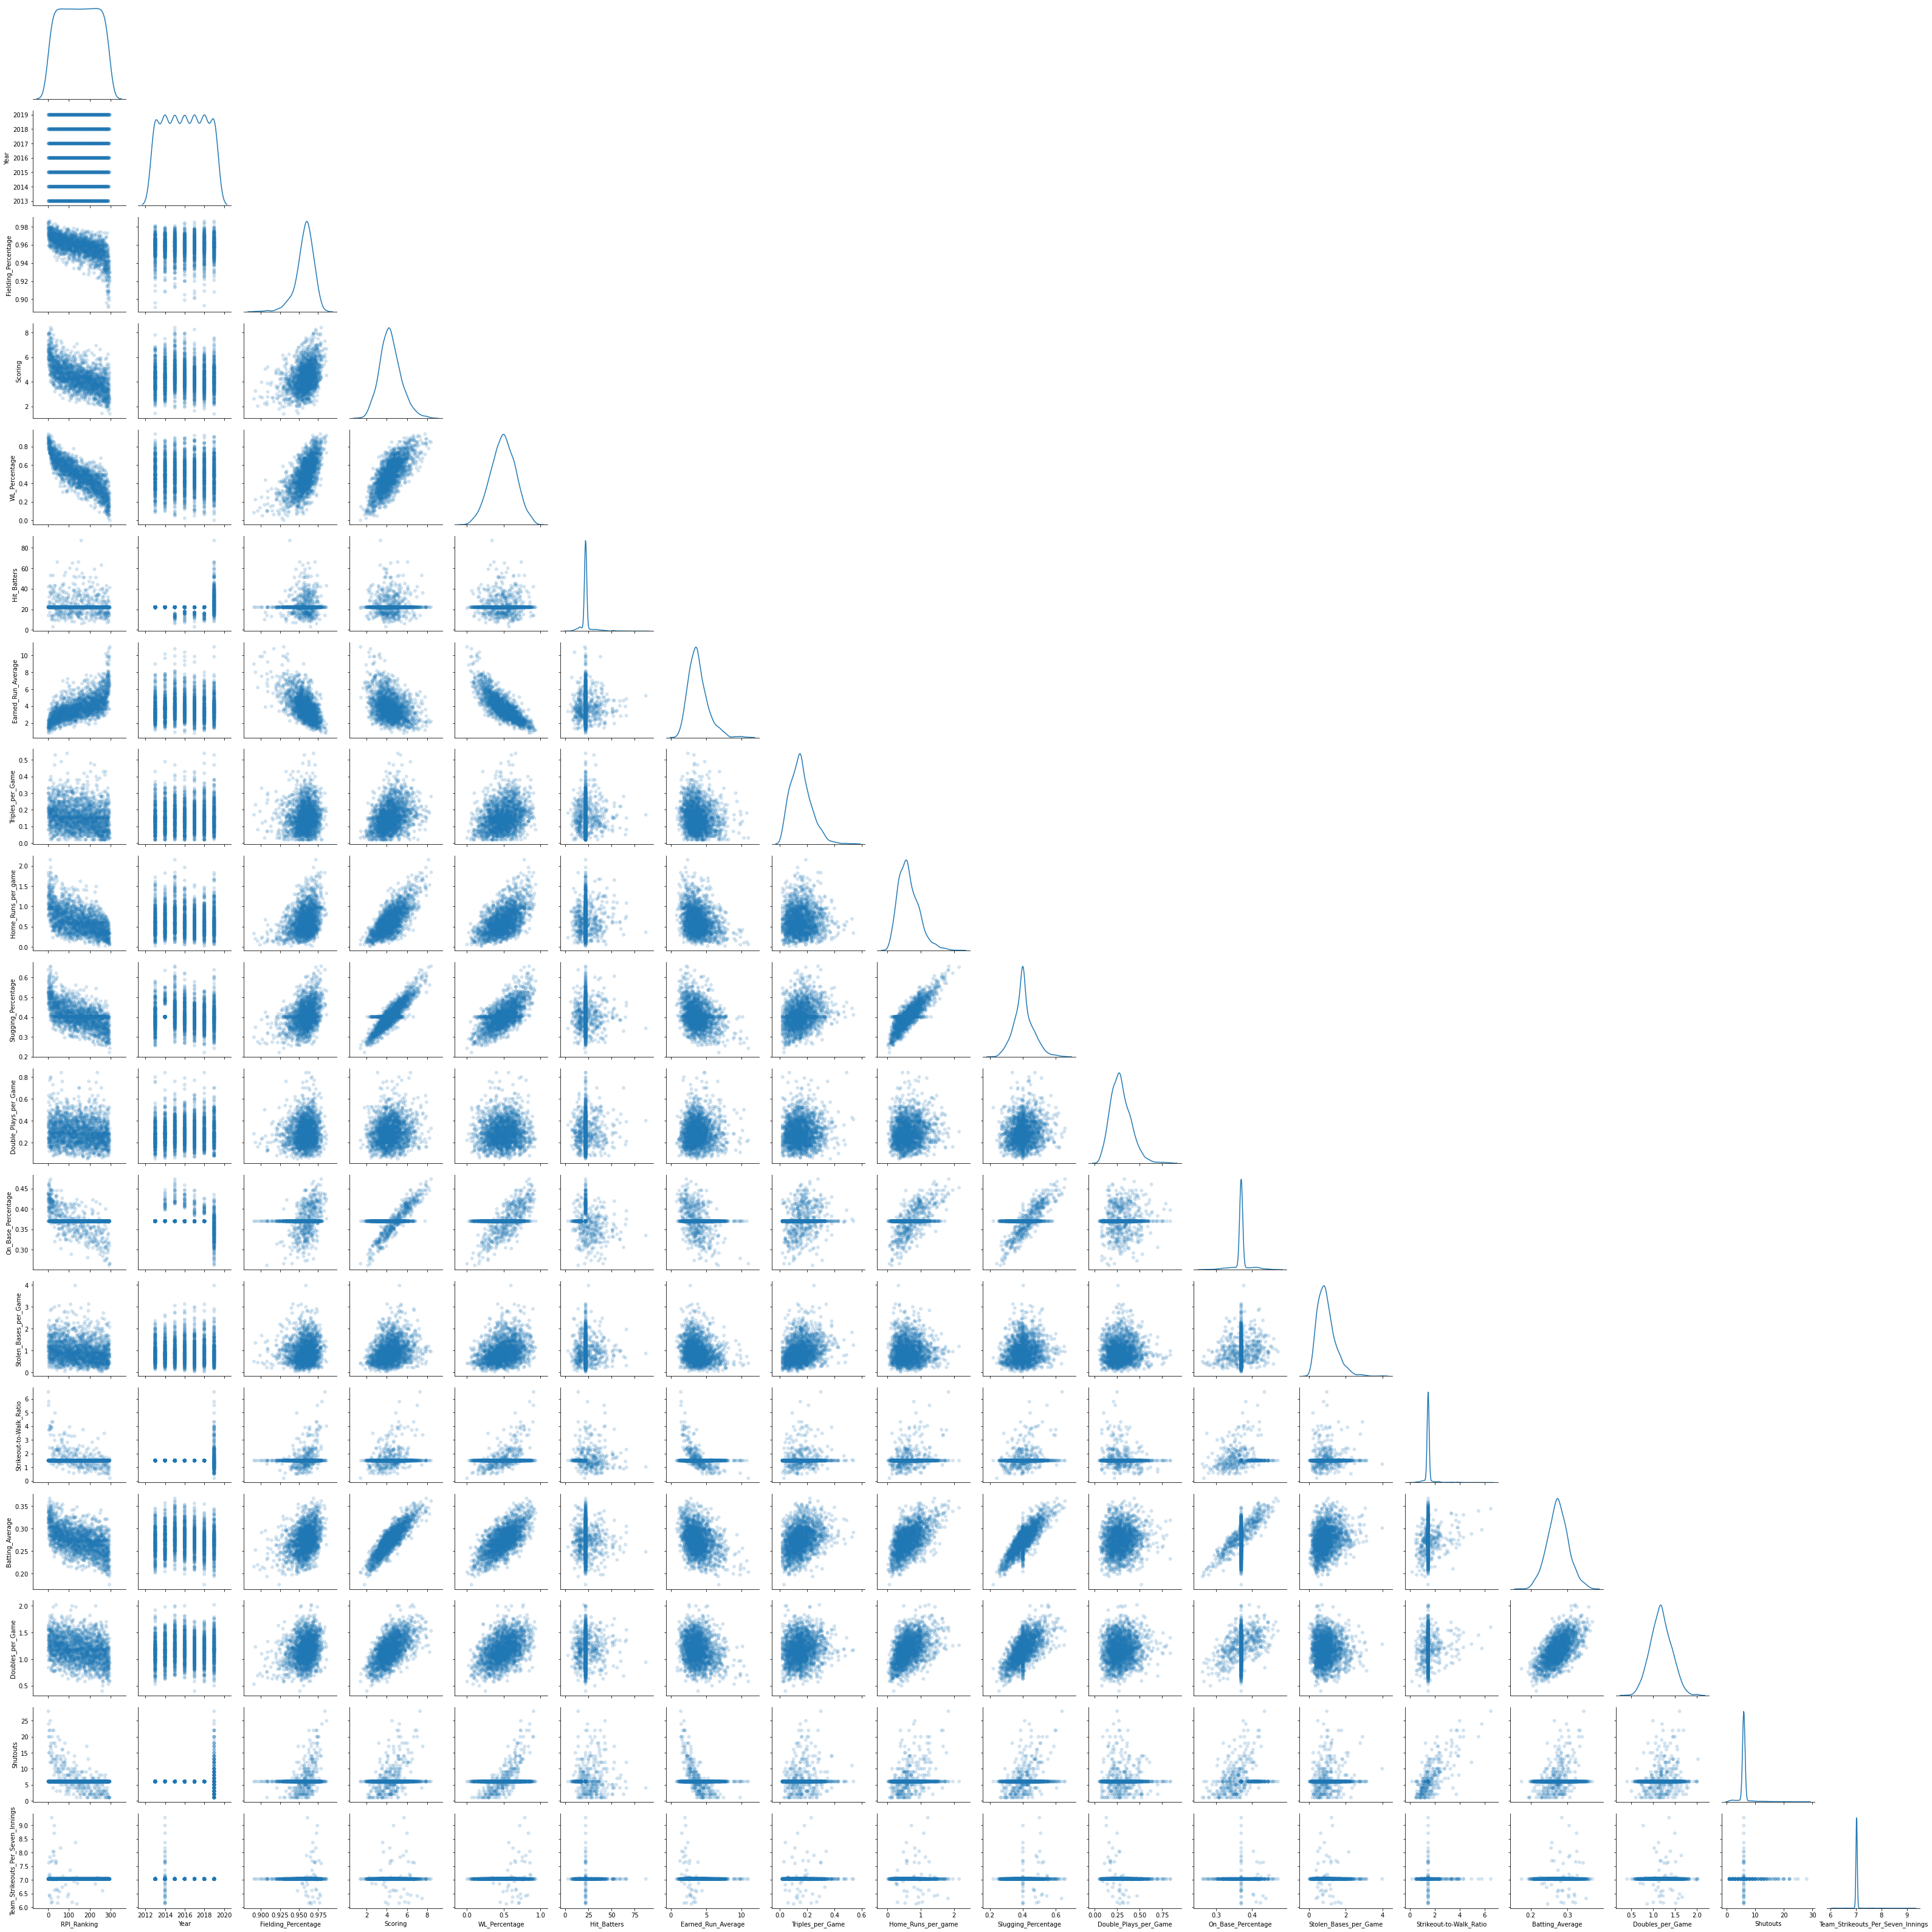

In [97]:
pair_stats = sns.pairplot(
    data=pd.concat([(y_RPI),X_imp_median[X_imp_median.columns[list(range(17))]]],axis=1),
    diag_kind='kde',plot_kws=dict(alpha=0.2,edgecolor=[]), diag_kws=dict(shade=False), corner=True)

### Imputation 2 - KNN

In [94]:
# squareroot of the observations is 45
imp_KNN = KNNImputer(missing_values=np.nan, n_neighbors=5)
imp_KNN.fit(X_dummy)
X_imp_KNN = pd.DataFrame(imp_KNN.transform(X_dummy))
X_imp_KNN.columns = X_dummy.columns
X_imp_KNN

Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0     2019.0                0.984     7.30          0.905         14.0   
1     2019.0                0.974     7.03          0.903         42.0   
2     2019.0                0.980     5.25          0.852         24.0   
3     2019.0                0.976     6.48          0.774         22.0   
4     2019.0                0.973     6.98          0.846         32.0   
...      ...                  ...      ...            ...          ...   
2063  2013.0                0.909     3.87          0.244         13.8   
2064  2013.0                0.949     2.87          0.167         13.2   
2065  2013.0                0.958     3.40          0.186         14.0   
2066  2013.0                0.891     2.61          0.083         12.4   
2067  2013.0                0.932     3.81          0.372         14.0   

      Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                   1.40             0.300                1.83   
1                   1.43             0.210                1.26   
2                   1.47             0.150                0.79   
3                   1.61             0.110                1.77   
4                   1.87             0.280                1.62   
...                  ...               ...                 ...   
2063                7.14             0.290                0.31   
2064                7.62             0.108                0.35   
2065                7.68             0.190                0.33   
2066                8.96             0.170                0.33   
2067                3.65             0.190                0.16   

      Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                   0.639                   0.25              0.4350   
1                   0.547                   0.23              0.4160   
2                   0.440                   0.21              0.3830   
3                   0.570                   0.29              0.3980   
4                   0.601                   0.37              0.4210   
...                   ...                    ...                 ...   
2063                0.365                   0.13              0.4024   
2064                0.348                   0.39              0.4024   
2065                0.333                   0.40              0.4024   
2066                0.298                   0.28              0.4038   
2067                0.314                   0.16              0.4066   

      Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                      0.97                    6.500            0.344   
1                      0.98                    5.520            0.339   
2                      0.80                    5.790            0.297   
3                      0.23                    3.710            0.318   
4                      1.77                    3.740            0.330   
...                     ...                      ...              ...   
2063                   0.96                    0.814            0.257   
2064                   0.33                    0.810            0.252   
2065                   0.37                    0.786            0.233   
2066                   0.50                    0.562            0.215   
2067                   0.98                    1.260            0.242   

      Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings  \
0                 1.60      28.0                              7.098   
1                 1.45      20.0                              7.160   
2                 1.20      24.0                              7.328   
3                 1.18      15.0                              7.328   
4                 1.58      22.0                              7.216   
...                ...       ...                                ...   
2063              1.13       1.8                              6.566   
2064            

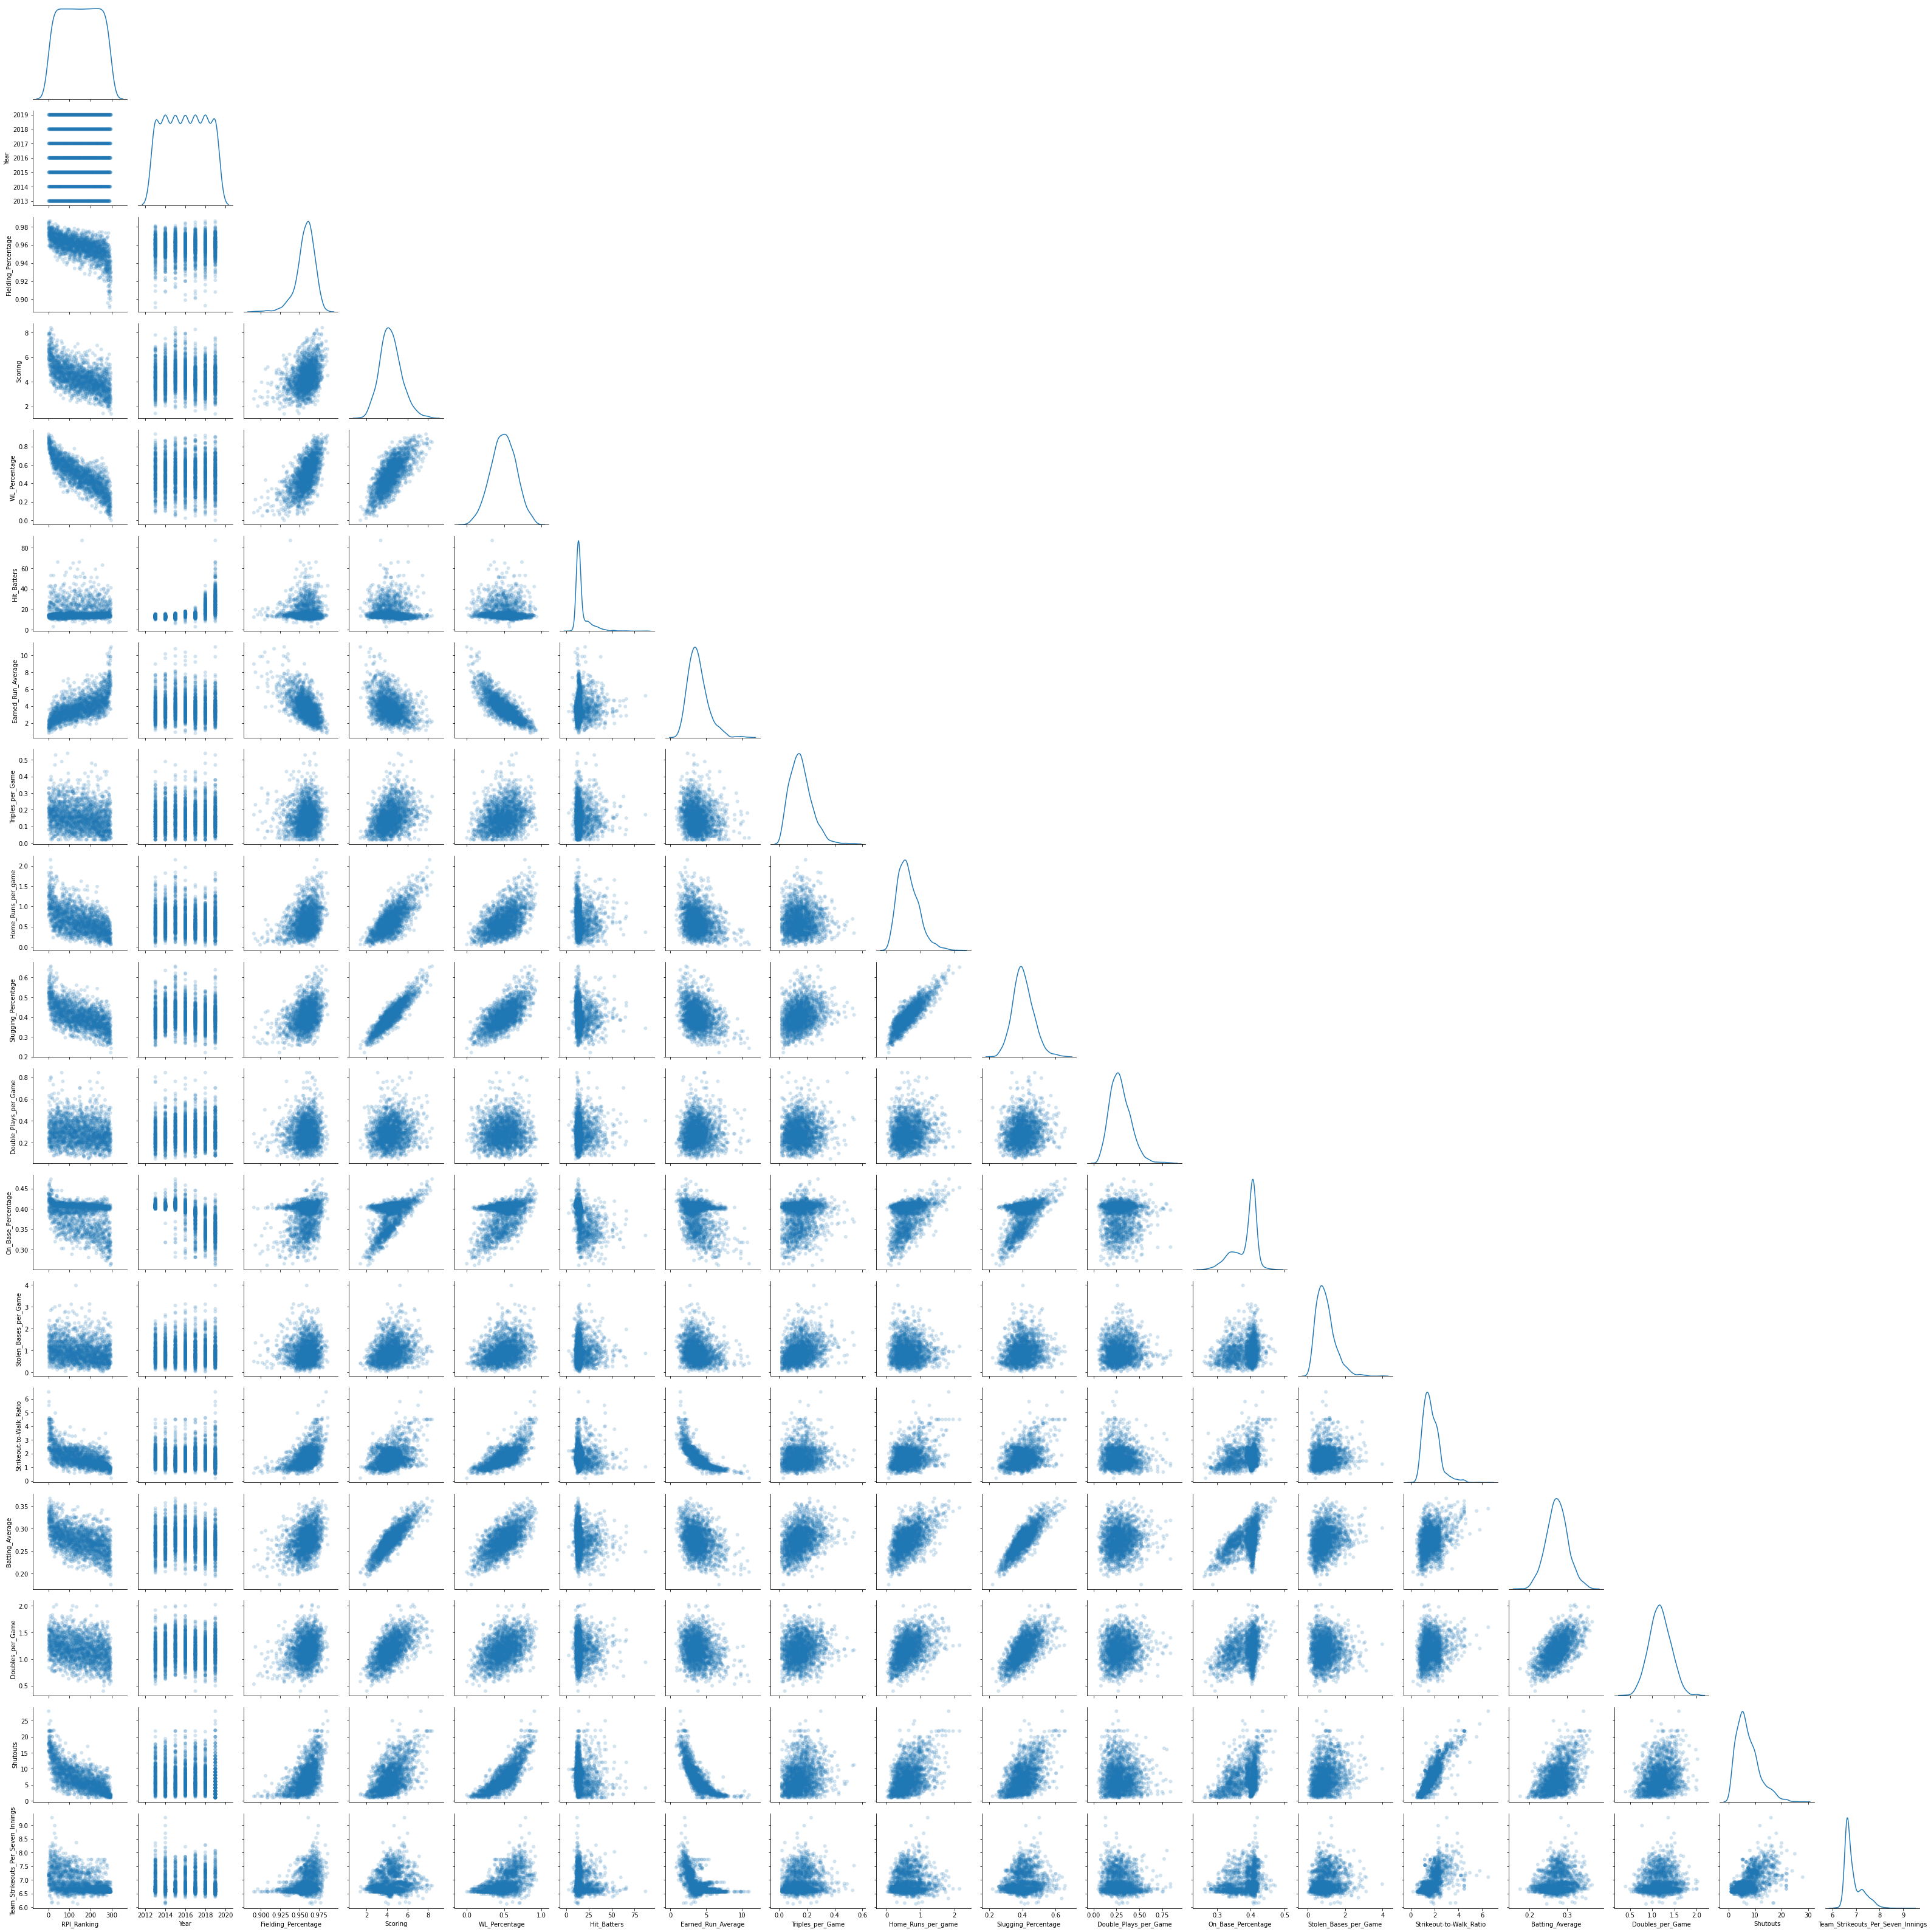

In [98]:
pair_stats = sns.pairplot(
    data=pd.concat([(y_RPI),X_imp_KNN[X_imp_KNN.columns[list(range(17))]]],axis=1),
    diag_kind='kde',plot_kws=dict(alpha=0.2,edgecolor=[]), diag_kws=dict(shade=False), corner=True)

In [96]:
%store X_imp_KNN
%store X_imp_median

Stored 'X_imp_KNN' (DataFrame)
Stored 'X_imp_median' (DataFrame)


### PCA/FAMD

In [106]:
X_mixed = X_imp_KNN.copy()
columns_categorical = X_mixed.columns[list(range(17,49))]
for idx,col in enumerate(columns_categorical):
    X_mixed[col] = X_mixed[col].astype(object)
print(X_mixed.dtypes)
X_mixed.head()

Year                                 float64
Fielding_Percentage                  float64
Scoring                              float64
WL_Percentage                        float64
Hit_Batters                          float64
Earned_Run_Average                   float64
Triples_per_Game                     float64
Home_Runs_per_game                   float64
Slugging_Percentage                  float64
Double_Plays_per_Game                float64
On_Base_Percentage                   float64
Stolen_Bases_per_Game                float64
Strikeout-to-Walk_Ratio              float64
Batting_Average                      float64
Doubles_per_Game                     float64
Shutouts                             float64
Team_Strikeouts_Per_Seven_Innings    float64
Conf__ACC                             object
Conf__ASUN                            object
Conf__America East                    object
Conf__Atlantic 10                     object
Conf__Big 12                          object
Conf__Big 

Year  Fielding_Percentage  Scoring  WL_Percentage  Hit_Batters  \
0  2019.0                0.984     7.30          0.905         14.0   
1  2019.0                0.974     7.03          0.903         42.0   
2  2019.0                0.980     5.25          0.852         24.0   
3  2019.0                0.976     6.48          0.774         22.0   
4  2019.0                0.973     6.98          0.846         32.0   

   Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0                1.40              0.30                1.83   
1                1.43              0.21                1.26   
2                1.47              0.15                0.79   
3                1.61              0.11                1.77   
4                1.87              0.28                1.62   

   Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                0.639                   0.25               0.435   
1                0.547                   0.23               0.416   
2                0.440                   0.21               0.383   
3                0.570                   0.29               0.398   
4                0.601                   0.37               0.421   

   Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                   0.97                     6.50            0.344   
1                   0.98                     5.52            0.339   
2                   0.80                     5.79            0.297   
3                   0.23                     3.71            0.318   
4                   1.77                     3.74            0.330   

   Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings Conf__ACC  \
0              1.60      28.0                              7.098       0.0   
1              1.45      20.0                              7.160       0.0   
2              1.20      24.0                              7.328       0.0   
3              1.18      15.0                              7.328       0.0   
4              1.58      22.0                              7.216       1.0   

  Conf__ASUN Conf__America East Conf__Atlantic 10 Conf__Big 12 Conf__Big East  \
0        0.0                0.0               0.0          1.0            0.0   
1        0.0                0.0               0.0          0.0            0.0   
2        0.0                0.0               0.0          0.0            0.0   
3        0.0                0.0               0.0          0.0            0.0   
4        0.0                0.0               0.0          0.0            0.0   

  Conf__Big Sky Conf__Big South Conf__Big Ten Conf__Big West Conf__C-USA  \
0           0.0             0.0           0.0            0.0         0.0   
1           0.0             0.0           0.0            0.0         0.0   
2           0.0             0.0           0.0            0.0         0.0   
3           0.0             0.0           0.0            0.0         0.0   
4           0.0             0.0           0.0            0.0         0.0   

  Conf__CAA Conf__Horizon Conf__IVY Conf__Ivy Conf__MAAC Conf__MAC Conf__MEAC  \
0       0.0           0.0       0.0       0.0        0.0       0.0        0.0   
1       0.0           0.0       0.0       0.0        0.0       0.0        0.0   
2       0.0           0.0       0.0       0.0        0.0       0.0        0.0   
3       0.0           0.0       0.0       0.0        0.0       0.0        0.0   
4       0.0           0.0       0.0       0.0        0.0       0.0        0.0   

  Conf__MVC Conf__MWC Conf__NEC Conf__OVC Conf__Pac-12 Conf__Patriot  \
0       0.0       0.0       0.0       0.0          0.0           0.0   
1       0.0       0.0       0.0       0.0          1.0           0.0   
2       0.0       0.0       0.0       0.0          1.0           0.0   
3       0.0       0.0       0.0       0.0          1.0           0.0   
4       0.0       0.0       0.0       0.0          0.0           0.0   

  Conf__SEC Conf__SWAC Conf__S

In [114]:
scaler = StandardScaler()
X_scaled = X_mixed.copy()
X_scaled[X_scaled.columns[list(range(0,17))]] = scaler.fit_transform(X_mixed[X_mixed.columns[list(range(0,17))]])
X_scaled

Year  Fielding_Percentage   Scoring  WL_Percentage  Hit_Batters  \
0     1.497136             2.203850  2.756619       2.501542    -0.394350   
1     1.497136             1.370752  2.502612       2.489464     3.240321   
2     1.497136             1.870611  0.828041       2.181485     0.903747   
3     1.497136             1.537372  1.985188       1.710459     0.644127   
4     1.497136             1.287443  2.455573       2.145252     1.942224   
...        ...                  ...       ...            ...          ...   
2063 -1.503423            -4.044385 -0.470222      -1.490106    -0.420312   
2064 -1.503423            -0.711993 -1.410992      -1.955093    -0.498198   
2065 -1.503423             0.037796 -0.912384      -1.840356    -0.394350   
2066 -1.503423            -5.543961 -1.655593      -2.462353    -0.602046   
2067 -1.503423            -2.128259 -0.526668      -0.717139    -0.394350   

      Earned_Run_Average  Triples_per_Game  Home_Runs_per_game  \
0              -1.766452          1.876654            3.813337   
1              -1.744767          0.712300            1.985011   
2              -1.715855         -0.063936            0.477444   
3              -1.614660         -0.581426            3.620881   
4              -1.426728          1.617909            3.139743   
...                  ...               ...                 ...   
2063            2.382510          1.747281           -1.062199   
2064            2.729462         -0.607301           -0.933896   
2065            2.772831          0.453555           -0.998047   
2066            3.698035          0.194810           -0.998047   
2067           -0.140116          0.453555           -1.543338   

      Slugging_Percentage  Double_Plays_per_Game  On_Base_Percentage  \
0                3.783025              -0.370134            1.457319   
1                2.295707              -0.545770            0.895024   
2                0.565892              -0.721406           -0.081594   
3                2.667536              -0.018863            0.362323   
4                3.168698               0.683680            1.042996   
...                   ...                    ...                 ...   
2063            -0.646596              -1.423949            0.492539   
2064            -0.921426               0.859316            0.492539   
2065            -1.163924               0.947134            0.492539   
2066            -1.729751              -0.106681            0.533971   
2067            -1.471087              -1.160495            0.616836   

      Stolen_Bases_per_Game  Strikeout-to-Walk_Ratio  Batting_Average  \
0                  0.039741                 6.812563         2.464576   
1                  0.060101                 5.415579         2.289146   
2                 -0.306379                 5.800463         0.815535   
3                 -1.466901                 2.835436         1.552341   
4                  1.668544                 2.878201         1.973373   
...                     ...                      ...              ...   
2063               0.019381                -1.292793        -0.587904   
2064              -1.263301                -1.298495        -0.763334   
2065              -1.181861                -1.332707        -1.429967   
2066              -0.917180                -1.652017        -2.061515   
2067               0.060101                -0.657023        -1.114194   

      Doubles_per_Game  Shutouts  Team_Strikeouts_Per_Seven_Innings Conf__ACC  \
0             1.774577  4.910239                           0.590317       0.0   
1             1.147619  3.019488                           0.754715       0.0   
2             0.102690  3.964864                           1.200179       0.0   
3             0.019096  1.837768                           1.200179       0.0   
4             1.690983  3.492176                           0.903203       1.0   
...                ...       ...                                

In [115]:
famd = prince.FAMD(
    n_components=49,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=2)
famd_X = famd.fit(X_scaled)

In [116]:
FAMD_X = pd.DataFrame()
FAMD_X['ExplaineInertia'] = famd_X.explained_inertia_
FAMD_X['EigenValues'] = famd_X.eigenvalues_
FAMD_X['CummExplaineInertia'] = FAMD_X.ExplaineInertia.cumsum()
print(famd_X.total_inertia_)
FAMD_X

0.0043309448960866075


ExplaineInertia  EigenValues  CummExplaineInertia
0          0.118481     0.000513             0.118481
1          0.044191     0.000191             0.162672
2          0.036016     0.000156             0.198688
3          0.030569     0.000132             0.229256
4          0.025437     0.000110             0.254693
5          0.025029     0.000108             0.279723
6          0.024391     0.000106             0.304114
7          0.024227     0.000105             0.328341
8          0.023873     0.000103             0.352214
9          0.023769     0.000103             0.375983
10         0.023705     0.000103             0.399688
11         0.023579     0.000102             0.423267
12         0.023510     0.000102             0.446777
13         0.023433     0.000101             0.470210
14         0.023409     0.000101             0.493618
15         0.023362     0.000101             0.516981
16         0.023304     0.000101             0.540284
17         0.023267     0.000101             0.563552
18         0.023157     0.000100             0.586709
19         0.023135     0.000100             0.609844
20         0.023024     0.000100             0.632868
21         0.022956     0.000099             0.655824
22         0.022937     0.000099             0.678761
23         0.022861     0.000099             0.701622
24         0.022826     0.000099             0.724448
25         0.022736     0.000098             0.747184
26         0.022724     0.000098             0.769907
27         0.022663     0.000098             0.792570
28         0.022611     0.000098             0.815180
29         0.022206     0.000096             0.837386
30         0.022114     0.000096             0.859501
31         0.020907     0.000091             0.880408
32         0.019163     0.000083             0.899570
33         0.018888     0.000082             0.918459
34         0.016191     0.000070             0.934650
35         0.011796     0.000051             0.946446
36         0.010935     0.000047             0.957381
37         0.007797     0.000034             0.965179
38         0.007602     0.000033             0.972781
39         0.006462     0.000028             0.979243
40         0.005935     0.000026             0.985178
41         0.004229     0.000018             0.989407
42         0.003423     0.000015             0.992831
43         0.002629     0.000011             0.995459
44         0.001572     0.000007             0.997031
45         0.001371     0.000006             0.998402
46         0.000840     0.000004             0.999243
47         0.000484     0.000002             0.999726
48         0.000274     0.000001             1.000000

In [118]:
famd_X_corr = famd_X.column_correlations(X_scaled).reset_index()
famd_X_corr

index         0         1         2         3  \
0                     Batting_Average  0.803004 -0.424986  0.065524  0.214467   
1                       Conf__ACC_0.0 -0.080950  0.047512 -0.067590  0.024808   
2                       Conf__ACC_1.0  0.080950 -0.047512  0.067590 -0.024808   
3                      Conf__ASUN_0.0 -0.062178 -0.112394  0.026317 -0.079404   
4                      Conf__ASUN_1.0  0.062178  0.112394 -0.026317  0.079404   
5              Conf__America East_0.0  0.026439  0.004120  0.017127  0.003388   
6              Conf__America East_1.0 -0.026439 -0.004120 -0.017127 -0.003388   
7               Conf__Atlantic 10_0.0  0.041494  0.014338  0.015831  0.019425   
8               Conf__Atlantic 10_1.0 -0.041494 -0.014338 -0.015831 -0.019425   
9                    Conf__Big 12_0.0 -0.142044 -0.001664 -0.006751 -0.008417   
10                   Conf__Big 12_1.0  0.142044  0.001664  0.006751  0.008417   
11                 Conf__Big East_0.0  0.008541  0.020552  0.014300  0.056886   
12                 Conf__Big East_1.0 -0.008541 -0.020552 -0.014300 -0.056886   
13                  Conf__Big Sky_0.0  0.062181  0.094988 -0.020985  0.018075   
14                  Conf__Big Sky_1.0 -0.062181 -0.094988  0.020985 -0.018075   
15                Conf__Big South_0.0  0.014156  0.027513  0.000942 -0.001202   
16                Conf__Big South_1.0 -0.014156 -0.027513 -0.000942  0.001202   
17                  Conf__Big Ten_0.0 -0.080728  0.013748 -0.019536 -0.001127   
18                  Conf__Big Ten_1.0  0.080728 -0.013748  0.019536  0.001127   
19                 Conf__Big West_0.0  0.004988 -0.090037  0.005279  0.029036   
20                 Conf__Big West_1.0 -0.004988  0.090037 -0.005279 -0.029036   
21                    Conf__C-USA_0.0 -0.013862 -0.036936 -0.002105 -0.039317   
22                    Conf__C-USA_1.0  0.013862  0.036936  0.002105  0.039317   
23                      Conf__CAA_0.0 -0.060014 -0.006109  0.008232 -0.023447   
24                      Conf__CAA_1.0  0.060014  0.006109 -0.008232  0.023447   
25                  Conf__Horizon_0.0  0.078961 -0.011928  0.005102  0.002163   
26                  Conf__Horizon_1.0 -0.078961  0.011928 -0.005102 -0.002163   
27                      Conf__IVY_0.0  0.043043  0.034032 -0.075947  0.000821   
28                      Conf__IVY_1.0 -0.043043 -0.034032  0.075947 -0.000821   
29                      Conf__Ivy_0.0  0.018806  0.015191  0.105146  0.070384   
30                      Conf__Ivy_1.0 -0.018806 -0.015191 -0.105146 -0.070384   
31                     Conf__MAAC_0.0  0.098579 -0.009188 -0.004714  0.083063   
32                     Conf__MAAC_1.0 -0.098579  0.009188  0.004714 -0.083063   
33                      Conf__MAC_0.0  0.019460 -0.025630 -0.003864  0.019159   
34                      Conf__MAC_1.0 -0.019460  0.025630  0.003864 -0.019159   
35                     Conf__MEAC_0.0  0.216428  0.068971  0.031087 -0.134309   
36                     Conf__MEAC_1.0 -0.216428 -0.068971 -0.031087  0.134309   
37                      Conf__MVC_0.0  0.006076 -0.020040  0.013436  0.059579   
38                      Conf__MVC_1.0 -0.006076  0.020040 -0.013436 -0.059579   
39                      Conf__MWC_0.0 -0.056773  0.128443 -0.053359  0.013581   
40                      Conf__MWC_1.0  0.056773 -0.128443  0.053359 -0.013581   
41                      Conf__NEC_0.0  0.075101 -0.036028  0.002709  0.110688   
42                      Conf__NEC_1.0 -0.075101  0.036028 -0.002709 -0.110688   
43                      Conf__OVC_0.0  0.010462 -0.049412  0.002048  0.010069   
44                      Conf__OVC_1.0 -0.010462  0.049412 -0.002048 -0.010069   
45                   Conf__Pac-12_0.0 -0.186720  0.037916  0.003153  0.051820   
46                   Conf__Pac-12_1.0  0.186720 -0.037916 -0.003153 -0.051820   
47                  Conf__Patriot_0.0  0.058374 -0.112189  0.025347 -0.048974   
48                  Conf__Patriot_1.0 -0.058374  0.112189 -0.02

<AxesSubplot:ylabel='index'>

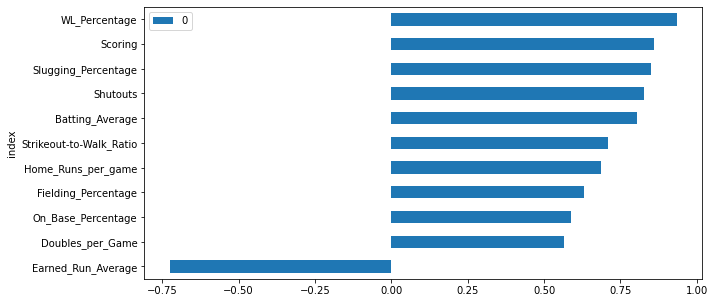

In [119]:
famd_X_corr[famd_X_corr[0].abs() >= 0.5].sort_values(by = 0).plot(x='index',y=0,kind='barh')

<AxesSubplot:ylabel='index'>

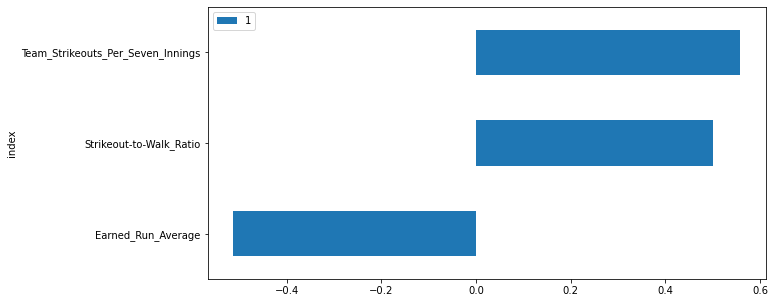

In [120]:
famd_X_corr[famd_X_corr[1].abs() >= 0.5].sort_values(by = 1).plot(x='index',y=1,kind='barh')

<AxesSubplot:ylabel='index'>

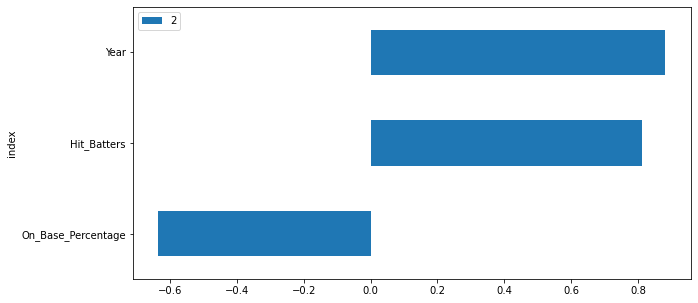

In [121]:
famd_X_corr[famd_X_corr[2].abs() >= 0.5].sort_values(by = 2).plot(x='index',y=2,kind='barh')

<AxesSubplot:ylabel='index'>

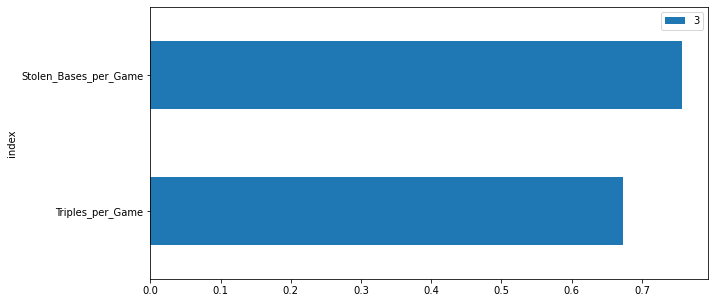

In [122]:
famd_X_corr[famd_X_corr[3].abs() >= 0.5].sort_values(by = 3).plot(x='index',y=3,kind='barh')

<AxesSubplot:ylabel='index'>

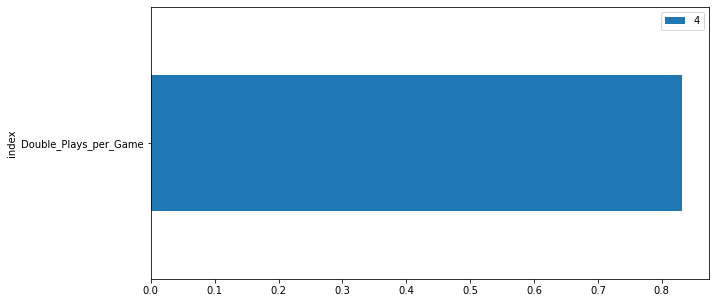

In [123]:
famd_X_corr[famd_X_corr[4].abs() >= 0.5].sort_values(by = 4).plot(x='index',y=4,kind='barh')

<AxesSubplot:ylabel='index'>

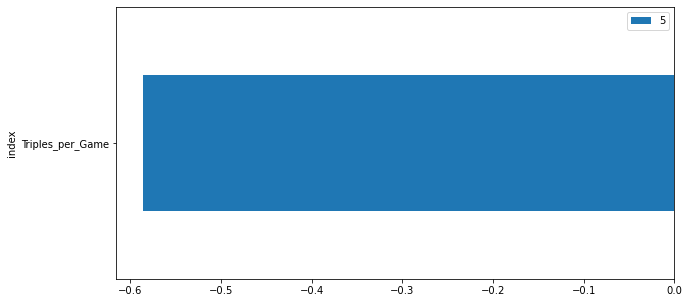

In [124]:
famd_X_corr[famd_X_corr[5].abs() >= 0.5].sort_values(by = 5).plot(x='index',y=5,kind='barh')

<AxesSubplot:ylabel='index'>

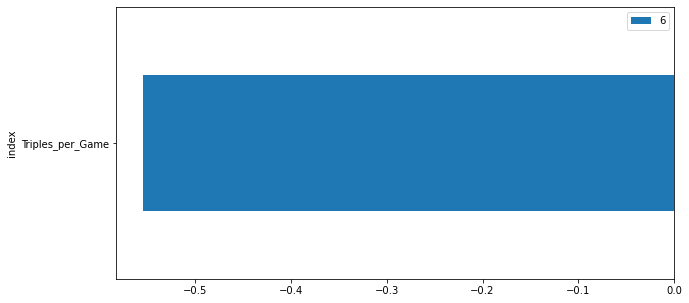

In [125]:
famd_X_corr[famd_X_corr[6].abs() >= 0.5].sort_values(by = 6).plot(x='index',y=6,kind='barh')

In [126]:
X_famd = famd_X.row_coordinates(X_scaled)
X_famd.head()

0         1         2         3         4         5         6   \
0  4.088210  0.387175  0.445653  0.163744 -0.851128 -0.214929  0.035298   
1  3.039649  0.573932  1.019195 -0.008529 -0.105167 -0.278156 -0.578188   
2  2.308711  1.463145  0.340674 -0.164757  0.032279 -0.304728 -0.623298   
3  2.422937  0.126035  0.628305 -0.688452  0.025794 -0.133299 -0.491045   
4  2.996733 -0.096362  1.312312  0.329128 -0.102805  0.639735 -0.084065   

         7         8         9         10        11        12        13  \
0  0.334836 -0.238593  0.132638 -0.096404 -0.230721  0.724759  0.239172   
1  1.381380  0.647713  0.348277  0.486808 -1.041180  0.607301  0.458557   
2  1.443160  0.583311  0.374074  0.512658 -1.057005  0.577237  0.498005   
3  1.337943  0.587932  0.312107  0.565866 -1.047365  0.558485  0.426575   
4 -0.309899  0.577889  0.009138  0.448259 -0.027963  0.309472  0.844465   

         14        15        16        17        18        19        20  \
0 -0.196974  0.123700 -0.659215  0.179900  0.149158 -0.141219  0.007681   
1 -0.665832  0.166477  0.448922  0.085372  0.095148 -0.387200  0.068609   
2 -0.651375  0.189152  0.472450  0.126613  0.092968 -0.322832  0.021193   
3 -0.714720  0.127740  0.482935  0.109800  0.076740 -0.317111  0.062534   
4  1.316197 -0.762520  0.088694  0.622191 -0.150506  0.283134 -0.122311   

         21        22        23        24        25        26        27  \
0  0.239291  0.107305  0.245343 -1.014234 -0.590747 -0.738947  1.852771   
1 -0.190076 -0.382729  0.054667  0.261591 -0.048113  0.250106 -0.285577   
2 -0.222821 -0.353709  0.040494  0.255637 -0.009808  0.255917 -0.263166   
3 -0.138181 -0.377141  0.077760  0.231932 -0.018397  0.233925 -0.298907   
4 -0.119393  0.286827 -0.173641 -0.005989  0.102410 -0.012245  0.026272   

         28        29        30        31        32        33        34  \
0 -0.265191  0.174415 -0.429634  0.164561  0.395233 -0.062863 -0.429432   
1 -0.010294 -0.068780 -0.059135  0.664097  0.022550 -0.298486 -0.370220   
2  0.004152 -0.029132 -0.081225  0.576958  0.513122 -0.594303 -0.365217   
3  0.035898 -0.028339 -0.063785  0.500007  0.386299  0.082602 -0.647256   
4 -0.047858  0.031675  0.014787  0.061146 -0.255501 -0.575104 -0.108417   

         35        36        37        38        39        40        41  \
0  0.033320 -0.627806 -0.459146  0.893360 -0.665163 -0.459985  0.193029   
1 -0.302473  0.322416 -0.080986  0.403295  0.381319 -0.723193 -0.212759   
2  0.032392  0.198868 -0.306602  0.109044 -0.225270 -0.517234 -0.165670   
3 -0.021146  0.167409 -0.083012  0.534428  0.000765  0.412972 -0.011803   
4  0.016573  0.075637  0.147530  0.558082  0.041496 -0.183988  0.152816   

         42        43        44        45        46        47        48  
0  1.167426 -0.532660  0.290076 -0.015480  0.042561  0.014975  0.022471  
1  0.612853 -0.224088  0.315445  0.238924  0.023582  0.023566 -0.026298  
2  0.807288 -0.191574  0.007938  0.148736  0.113365 -0.006232 -0.033362  
3 -0.041421 -0.221896  0.274458 -0.047145 -0.054609 -0.022842 -0.002856  
4  0.475336 -0.251809 -0.073757 -0.246787  0.035299 -0.019986  0.030788

In [127]:
%store X_famd

Stored 'X_famd' (DataFrame)


<AxesSubplot:ylabel='index'>

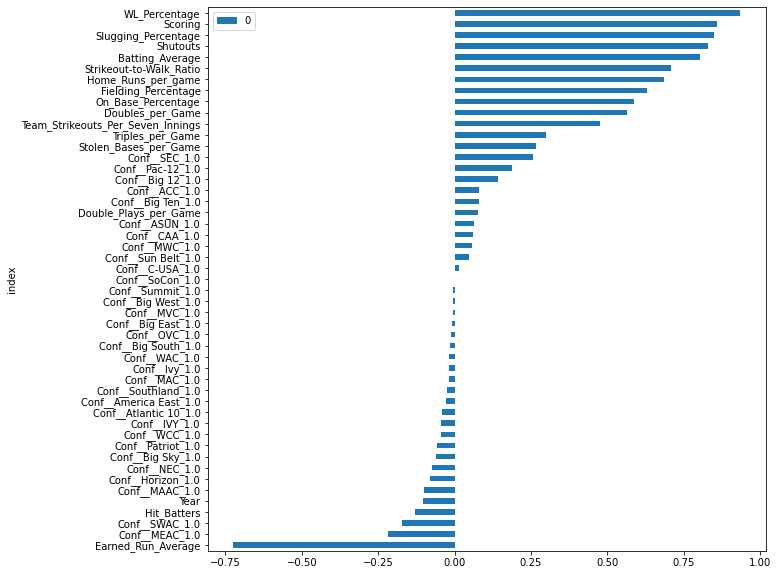

In [129]:
plt.rcParams['figure.figsize'] = (10, 10)
famd_X_corr1 = famd_X_corr.copy()
famd_X_corr1 = famd_X_corr1[~famd_X_corr1['index'].str.contains('_0')]
famd_X_corr1.sort_values(by = 0).plot(x='index',y=0,kind='barh')